# Least Squares Classification

- Classification binaire et problématique des données aberrantes
- Classification multi-classe

In [444]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Classification Binaire

### Généartion de données pour la classification

In [229]:
# Génération aléatoire de données pour deux classes
np.random.seed(99)  # Pour reproduire les mêmes données aléatoires
num_samples = 500  # Nombre d'échantillons par classe

# Génération des données de la classe 1
x1 = np.random.normal(size=num_samples)
x2 = np.random.normal(size=num_samples)
y1 = np.ones(num_samples)  # Labels pour la classe 1

# Génération des données de la classe 2
x3 = np.random.normal(3, 1, num_samples)
x4 = np.random.normal(3, 1, num_samples)
y2 = np.ones(num_samples) * -1  # Labels pour la classe 2

# Concaténation des données des deux classes
data_x1 = np.concatenate((x1, x3))
data_x2 = np.concatenate((x2, x4))
# nos labels
y = np.concatenate((y1, y2))

# notre jeux de données avec les labels
data = np.column_stack((data_x1, data_x2, y))

# avant d'appliquer notre classifieur nous allons juste faire un mélange de nos données sur notre tableau.
np.random.shuffle(data)

### Visualisation

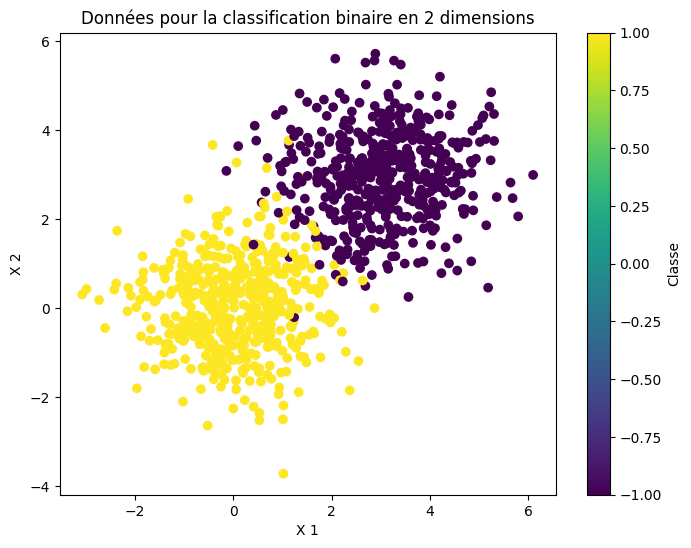

In [230]:
# Affichage des données générées
plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap='viridis')
plt.title('Données pour la classification binaire en 2 dimensions')
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.colorbar(label='Classe')
plt.show()


### Préparation de la données

**On ajoute une colonne de biais contenant des valeurs de 1 à notre matrice de données**

In [231]:
X = np.insert(data[:, 0:2], 0, 1., axis=1)
y = data[:, 2]

**Données de d'entrainement et de test**

In [232]:
X_train, X_test, y_train, y_test = X[:700,:], X[700:,:], y[:700], y[700:]
print(f"X_train : {X_train.shape} \t y_train : {y_train.shape}")
print(f"X_test : {X_test.shape} \t y_test : {y_test.shape}")


X_train : (700, 3) 	 y_train : (700,)
X_test : (300, 3) 	 y_test : (300,)


On applique la formule pour estimer nos poids $\tilde{\mathbf{w}}$.

$$ \tilde{\mathbf{w}} = (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}})^{-1} \tilde{\mathbf{X}}^T \mathbf{t} $$

Dis autrement nous allons chercher à trouver une ligne (ou, dans une dimension supérieure, un hyperplan) qui sépare l'espace d'entrée en deux régions distinctes, une pour chaque classe. Si une telle division de l'espace existe, on dit que les deux classes sont linéairement séparables.  

Étant donné une variable aléatoire $X=(X_1,X_2, \dots, X_n)^T$, un vecteur de poids $\beta=(\beta_1, \beta_2, \dots, \beta_n)^T$, et un biais $\beta_0$, nous discriminons la classe à laquelle $X$ appartient en fonction de la sortie de la fonction suivante :

$$
    \delta(X) = \begin{cases} \: \; \; 1 & \: \; \text{si } X^T \beta+ \beta_0 \geq  0 \\  -1 & \: \text{ si }  X^T \beta+ \beta_0 <  0 \end{cases}
$$


où les sorties +1 et -1 indiquent l'appartenance de X à la classe un ou à la classe deux, respectivement. Une telle fonction est clairement déterministe.

In [233]:
Xtranspose = X_train.transpose()
dotProduct = Xtranspose.dot(X_train)
inverse = np.linalg.pinv(dotProduct)
f = inverse.dot(Xtranspose)
w = f.dot(y_train)
w

array([ 0.85, -0.28, -0.27])

#### Visualisation de notre frontière de décision

On utilisant la fonction discriminante notre frontière de décision est trouvée en la fixant à zéro. donc nous avons :

$$
    \delta(x) = 0  \\
    x^t \beta + \beta_0 = 0 \\
    \beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0 \\
    x_2 = - \frac{\beta_0 + \beta_1 x_1}{\beta_2} 
$$

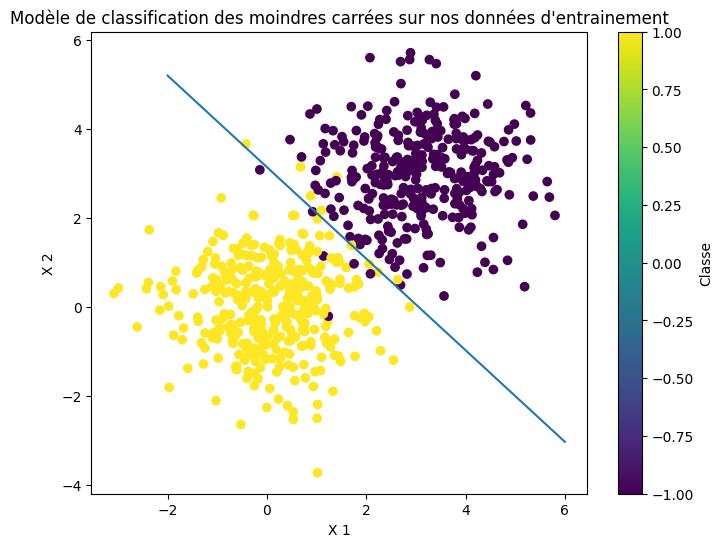

In [234]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:,1], X_train[:,2], c=y_train, cmap='viridis')
plt.title("Modèle de classification des moindres carrées sur nos données d'entrainement")
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.colorbar(label='Classe')

# ajout de notre ligne de régression
line_x = np.linspace(-2, 6)
line_y = -w[0] / w[2] - (w[1] / w[2]) * line_x

plt.plot(line_x, line_y)
plt.show()



### Prédiction

$$
    \hat{t} = \begin{cases} \: \; \; 1 & \: \; \text{si } \hat{y} \geq  0 \\  -1 & \: \text{ si }  \hat{y} <  0 \end{cases}
$$

In [235]:
# prediction des differents points de notre jeux de données de test
y_pred = X_test.dot(w)
# classification
y_class = np.array([1 if i >=0 else -1 for i in X_test.dot(w)])

#### Visualisaiton

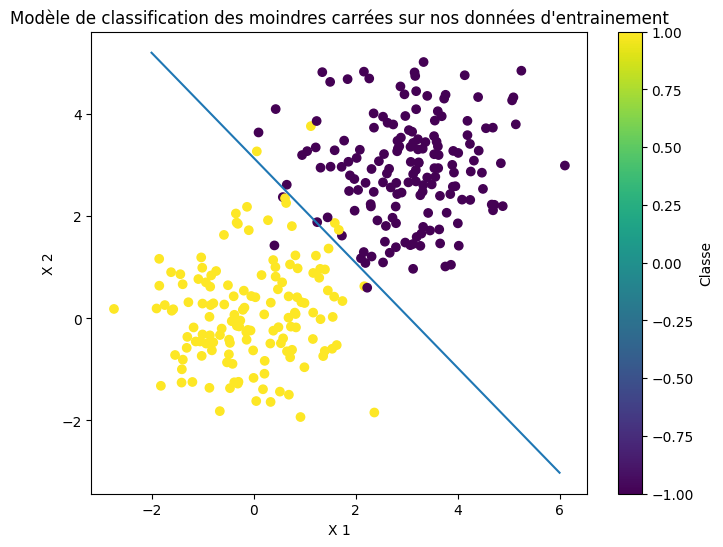

In [236]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,1], X_test[:,2], c=y_test, cmap='viridis')
plt.title("Modèle de classification des moindres carrées sur nos données tests")
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.colorbar(label='Classe')

# ajout de notre ligne de régression
line_x = np.linspace(-2, 6)
line_y = -w[0] / w[2] - (w[1] / w[2]) * line_x

plt.plot(line_x, line_y)
plt.show()


Visuellement, il est évident que la droite que nous avons créée forme une frontière nette entre les deux classes simulées. Cependant, dans la suite, nous étudierons comment des valeurs aberrantes peuvent avoir un impact sur notre classifieur.

#### Matrice de confusion

In [237]:
def confusion_matrix(k, real, pred):
    cm = np.zeros([k, k])
    for i in range(len(real)):
        cm[0 if int(real[i]) < 0 else int(real[i])][0 if int(pred[i]) < 0 else int(pred[i])] += 1
        
    return cm.astype(int)

In [239]:
cm = confusion_matrix(2,y_test, y_class)

Visualisation de notre matrice de confusion

In [241]:
def plot_cm(classes, cm, title=None):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

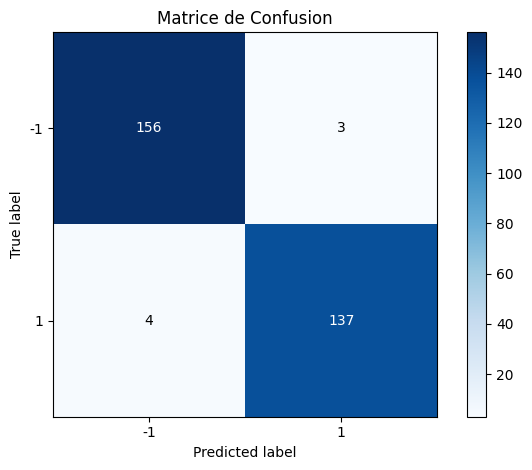

In [244]:
np.set_printoptions(precision=2)
class_names = ["-1","1"]
plot_cm(classes=class_names, cm = cm, title='Matrice de Confusion')
plt.show()

Ceci est appuyé par notre matrice de confusion qui indique un faible nombre de faux négatifs (3) et de faux positifs (4).

### Métrique

In [253]:
TN, FP, FN, TP = cm.ravel()
print(f"True Negatif: {TN} \t False Positive: {FP} \t Flase Negative: {FN} \t True Positive:  {TP}")

True Negatif: 156 	 False Positive: 3 	 Flase Negative: 4 	 True Positive:  137


In [263]:
# Précision
precision = TP/(TP+FP)

# Rappel
rappel = TP/(TP+FN)

# F1 score
F1 = (2*precision*rappel)/(precision+rappel)

# Accuracy
accuracy = (TP+TN)/(TP+FP+FN+TN)


print(f"Précision: {np.round(precision,3)}\t Rappel: {np.round(rappel,3)}\t F1-score: {np.round(F1,3)}\t Accuracy: {np.round(accuracy,3)}")

Précision: 0.979	 Rappel: 0.972	 F1-score: 0.975	 Accuracy: 0.977


Les métriques indiquent des résultats satisfaisants, notamment avec : 
- Précision: 0.979
- Rappel: 0.972
- F1-score: 0.975
- Accuracy: 0.977

#### Courbe ROC

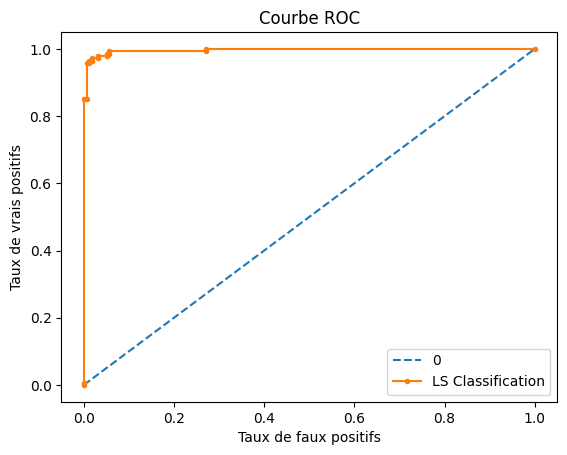

AUC = 0.996


In [450]:
n_fpr, n_tpr, _ = roc_curve(y_test, [0 for _ in range(len(y_test))])
ls_fpr, ls_tpr, trh = roc_curve(y_test, y_pred)
# plot the roc curve for the model
plt.plot(n_fpr, n_tpr, linestyle='--', label='0')
plt.plot(ls_fpr, ls_tpr, marker='.', label='LS Classification')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()

plt.title("Courbe ROC")
# show the plot
plt.show()

print(f"AUC = {round(auc(ls_fpr, ls_tpr), 3)}")

L’aire sous la courbe ROC est très élevée (0.996), proche de la valeur maximale de 1. Cela signifie que le modèle a une excellente capacité à distinguer entre les deux classes, avec des taux de vrai positif élevés tout en maintenant un faible taux de faux positif.

### Données abberante 

Nous allons générer d'autres données aberrantes pour évaluer si nos performances restent constantes dans ces conditions.

In [431]:
np.random.seed(99) 

# Génération des données de la classe 1
outliers_size= 200

x1_b = np.append(np.random.normal(size=num_samples-outliers_size), np.array([np.random.uniform(low=-8, high=-4) for _ in range(outliers_size)]))
#x1_b = np.append(np.random.normal(size=num_samples-50), np.random.normal(size=50) * np.random.normal(4,2,1))
x2_b = np.append(np.random.normal(size=num_samples-outliers_size), np.array([np.random.uniform(low=-8, high=-4) for _ in range(outliers_size)]))
y1_b = np.ones(num_samples)  # Labels pour la classe 1

# Génération des données de la classe 2
x3_b =  np.random.normal(3, 1, num_samples)
x4_b =  np.random.normal(3, 1, num_samples)
y2_b = np.ones(num_samples) * -1  # Labels pour la classe 2


# Concaténation des données des deux classes
data_x1_b = np.concatenate((x1_b, x3_b))
data_x2_b = np.concatenate((x2_b, x4_b))
# nos labels
y_b = np.concatenate((y1_b, y2_b))

# notre jeux de données avec les labels
data_b = np.column_stack((data_x1_b, data_x2_b, y_b))

# avant d'appliquer notre classifieur nous allons juste faire un mélange de nos données sur notre tableau.
np.random.shuffle(data_b)

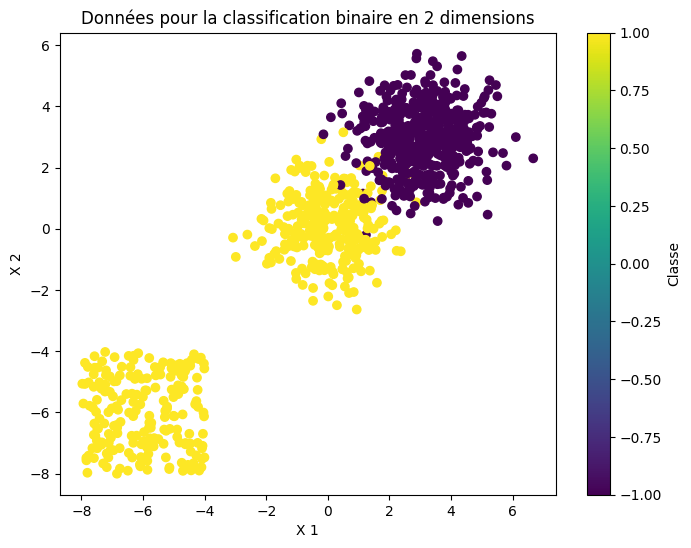

In [432]:
# Affichage des données générées
plt.figure(figsize=(8, 6))
plt.scatter(data_b[:,0], data_b[:,1], c=data_b[:,2], cmap='viridis')
plt.title('Données pour la classification binaire en 2 dimensions')
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.colorbar(label='Classe')
plt.show()


In [433]:
X_o = np.insert(data_b[:, 0:2], 0, 1., axis=1)
y_o = data_b[:, 2]

X_train_o, X_test_o, y_train_o, y_test_o = X_o[:700,:], X_o[700:,:], y_o[:700], y_o[700:]

Xtranspose_o = X_train_o.transpose()
dotProduct_o = Xtranspose_o.dot(X_train_o)
inverse_o = np.linalg.pinv(dotProduct_o)
f_o = inverse_o.dot(Xtranspose_o)
w_o = f_o.dot(y_train_o)

Classification sur nos données de test

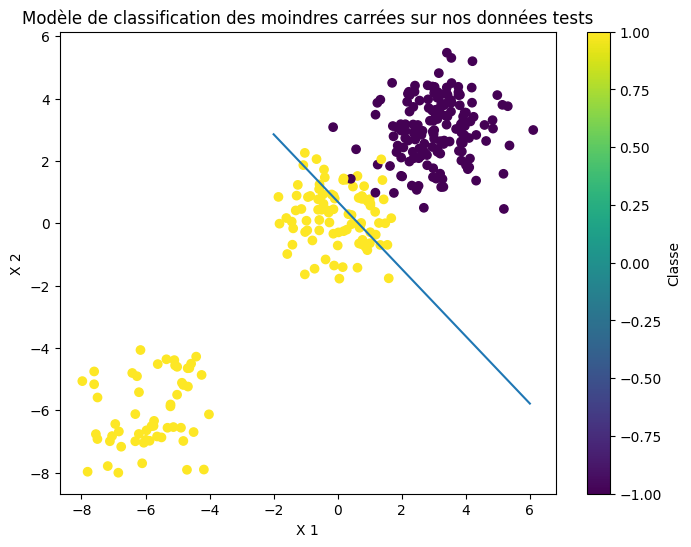

In [438]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_o[:,1], X_test_o[:,2], c=y_test_o, cmap='viridis')
plt.title("Modèle de classification des moindres carrées sur nos données tests")
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.colorbar(label='Classe')

# ajout de notre ligne de régression
line_x_o = np.linspace(-2, 6)
line_y_o = -w_o[0] / w_o[2] - (w_o[1] / w_o[2]) * line_x_o

plt.plot(line_x_o, line_y_o)
plt.show()

Visuellement, il est déjà apparent que la frontière de décision est davantage orientée vers notre classe 1 en raison de la présence de données aberrantes.

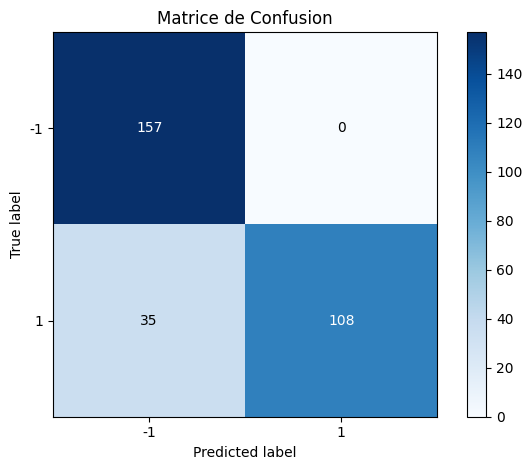

In [439]:
# prediction des differents points de notre jeux de données de test
y_pred_o = X_test_o.dot(w_o)
# classification
y_class_o = np.array([1 if i >=0 else -1 for i in X_test_o.dot(w_o)])
cm_o = confusion_matrix(2,y_test_o, y_class_o)

np.set_printoptions(precision=2)
class_names = ["-1","1"]
plot_cm(classes=class_names, cm = cm_o, title='Matrice de Confusion')
plt.show()

La matrice de confusion révèle un taux de faux positive plus élevé (35).

Métriques

In [441]:
TN_o, FP_o, FN_o, TP_o = cm_o.ravel()

# Précision
precision_o = TP_o/(TP_o+FP_o)

# Rappel
rappel_o = TP_o/(TP_o+FN_o)

# F1 score
F1_o = (2*precision_o*rappel_o)/(precision_o+rappel_o)

# Accuracy
accuracy_o = (TP_o+TN_o)/(TP_o+FP_o+FN_o+TN_o)


print(f"Précision: {np.round(precision_o,3)}\t Rappel: {np.round(rappel_o,3)}\t F1-score: {np.round(F1_o,3)}\t Accuracy: {np.round(accuracy_o,3)}")

Précision: 1.0	 Rappel: 0.755	 F1-score: 0.861	 Accuracy: 0.883


Nos métriques montrent clairement que la présence de données aberrantes a une influence sur notre modèle de classification, se traduisant par un rappel, un F1-score et une précision moins élevés.

## Classification Non Binaire

## Jeu de données MNIST

Le jeu de données MNIST est une base de données classique utilisée pour entraîner et tester des modèles de reconnaissance de chiffres manuscrits. Il contient 60 000 exemples d'images en noir et blanc de chiffres manuscrits de 0 à 9. Sur un total de 43 personnes, 30 ont contribué à l'ensemble de formation et 13 à l'ensemble de test. Les images bitmap 32x32 sont divisées en blocs non chevauchants de 4x4 et le nombre de pixels présents est compté dans chaque bloc. Cela génère une matrice d'entrée de 8x8 où chaque élément est un nombre entier compris entre 0 et 16. Cette méthode réduit la dimensionnalité et permet d'éviter les petites distorsions.

source :  [Optical Recognition of Handwritten Digits](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

### Import de notre dataset

In [457]:
digits = datasets.load_digits()

#### Plot Digit

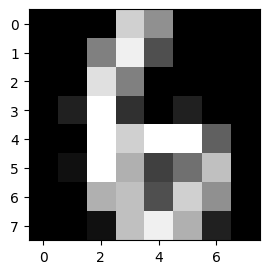

In [458]:
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.data[272].reshape((8,8)), cmap='gray')
plt.show()

**On ajoute une colonne de biais contenant des valeurs de 1 à notre matrice de données**

In [459]:
# On ajoute 1 à la première colonne de notre matrice de données pour introduire le biais.
X = np.insert(digits.data, 0, 1., axis=1)

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, digits.target, test_size=0.3, random_state=42)

In [461]:
print(f"X_train : {X_train.shape} \t y_train : {y_train.shape}")
print(f"X_test : {X_test.shape} \t y_test : {y_test.shape}")

X_train : (1257, 65) 	 y_train : (1257,)
X_test : (540, 65) 	 y_test : (540,)


L'objectif est de créer K modèles pour chaque classe, où $k = \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$. Ensuite, pour chaque classe k, la classe prédite est sélectionnée en se basant sur la valeur de prédiction la plus élevée parmi les différents modèles correspondant à cette classe."

$$\hat{t}(x) = \underset{k}{\arg \max} \;  \hat{y}_{k}(x)$$

Nous produisons également une sortie sous forme de tableau qui donne la probabilité pour chaque classe prédite via la fonction sigmoid, afin de ramener les prédictions $\hat{y}$ à des valeurs entre 0 et 1.

$$ \frac{1}{1+e^{-\hat{y}}} $$


### Formule de calcul

On crée une fonction pour le calcul de notre formule :
$$ \tilde{\mathbf{W}} = (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}})^{-1} \tilde{\mathbf{X}}^T \mathbf{T} $$

notre fonction vas calculer une partie de notre formule sans le $T$

$$ (\tilde{\mathbf{X}}^T \tilde{\mathbf{X}})^{-1} \tilde{\mathbf{X}}^T $$

### Prépration de la données

Pour chaque catégorie ou "label", on veut créer des vecteurs T spécifiques. Pour ce faire, on commence par récupérer les différents indices correspondant à chacun de nos labels. Ensuite, on attribue la valeur 1 à l'indice correspondant au label et -1 aux autres. Ces vecteurs vont servir à construire différents modèles pour chaque label.

$$
    {t}(x) = \begin{cases} \: \; \; 1 & \: \; \text{si } k \\ 
    -1 & \: \text{ sinon} \end{cases}
$$




In [462]:
# on récupère les indices pour notre label
def get_number_index(number, y):    
    return [i for i, n in enumerate(y) if n == number]

In [463]:
# on met 1 si c'est le label qu'on veut prédire, sinon -1.
"""
    number: le chiffre (classe) sur lequel on veut crée notre modèle
    y: données de nos classes
    
    Retourne: t un vecteur qui contient 1 si c'est notre label -1 sinon
    
    Cette fonction crée un vecteur de labels (1 ou -1) en fonction de la classe sélectionnée
"""
def get_t(number, y):
    t = np.zeros(len(y))
    idx = get_number_index(number, y)
    for i, _ in enumerate(y):
        t[i] = 1 if i in idx else -1
    return t

In [464]:
# calcul de la formule sans T
def formula(x):
    Xtranspose = x.transpose()
    dotProduct = Xtranspose.dot(x)
    inverse = np.linalg.pinv(dotProduct)
    return inverse.dot(Xtranspose)

In [465]:
"""
    X_train: données d'entraînement
    y_train: cible d'entraînement
    digit: le nombre à classifier
    
    Retourne: l'estimation de nos w
    
    Cette fonction calcule la formule décrite précédemment pour la classification least squares.
"""

def get_w(x_train, y_train, digit):
    t = get_t(digit, y_train)
    return formula(x_train).dot(t)

In [466]:
"""
    k: nombre de classes, dans notre cas 10 (de 0 à 9)
    X_train: données d'entraînement
    y_train: cible d'entraînement
    
    Retourne: une liste de K modèles
    
    Cette fonction retourne une liste de K modèles en utilisant la méthode du moindre carré (least squares) calculée par get_w().
"""

def model(K, X_train, y_train):
    models = []
    for k in range(K):
        models.append(get_w(X_train, y_train, k))
    return [get_w(X_train, y_train, k) for k in range(K)]

In [467]:
# retourn une valeur entre 0 et 1 (une probabilité) grâce à la fonction sigmoid.
def sigmoid(pred):
    return 1/(1 + np.exp(-pred))

In [496]:
"""
    models : liste des modèles calculés avec la fonction model pour chaque classe
    X_test : données de test à classifier
    
    Retourne : 
        p_class: la classe prédite
        pred: un tableau contenant la probabilité d'appartenance à chaque classe (ici K=10)
        real_pred: un tableau contenant la prédiction de chaque modèle pour chaque classe (ici K=10)
    
    Cette fonction calcule les prédictions via nos différents modèles (10 modèles pour chaque classe) sur les données de test.
"""

def class_prediction(models, X_test):
    p_class = np.zeros(len(X_test), dtype=float)
    pred = np.zeros((len(X_test), len(models)), dtype=float)
    real_pred = np.zeros((len(X_test), len(models)), dtype=float)
    
    for i, n in enumerate(X_test):
        c = np.zeros(len(models))
        for j, m in enumerate(models):
            c[j] = n.dot(m)
        maxw = np.amax(c)
        classr = np.where(c == np.amax(maxw))[0]
        p_class[i] = classr[0]
        pred[i] = sigmoid(c)
        real_pred[i] = c
        
    return p_class, pred, real_pred

In [497]:
# on génère nos modèles pour nos 10 classes {0,1,2,3,4,5,6,7,8,9,10}
m = model(10, X_train, y_train)

#### Prédiction

In [498]:
# on prédit la classe pour chaque nombre dans notre matrice X_test
class_predicted, prob, real_pred = class_prediction(m, X_test)

Voici un tableau présentant les prédictions de classe ainsi que les probabilités d'appartenance à chacune d'entre elles.

In [495]:
result = pd.DataFrame(data=prob.round(4), columns=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
result.insert(loc=0, column='Predicted Label', value=class_predicted.astype(int))
result.insert(loc=0, column='Real Label', value=y_test)
result

,Real Label,Predicted Label,0,1,2,3,4,5,6,7,8,9
0,6,6,0.2651,0.2891,0.2352,0.1932,0.2633,0.2952,0.5986,0.3361,0.2977,0.3932
1,9,9,0.3350,0.2304,0.2664,0.3507,0.3533,0.3828,0.1714,0.2487,0.2883,0.5469
2,3,3,0.2272,0.2678,0.2765,0.6342,0.2374,0.2889,0.3198,0.2871,0.3014,0.3131
3,7,7,0.3320,0.3189,0.2685,0.2684,0.2162,0.3736,0.2949,0.5008,0.2388,0.3308
4,2,2,0.2976,0.2659,0.5248,0.3880,0.1989,0.2757,0.3299,0.2567,0.3303,0.2827
...,...,...,...,...,...,...,...,...,...,...,...,...
535,4,1,0.3072,0.5288,0.1841,0.2302,0.4953,0.2247,0.2438,0.4147,0.2964,0.2675
536,7,7,0.2814,0.1813,0.2947,0.2384,0.2438,0.2783,0.2997,0.7672,0.3800,0.2158
537,0,0,0.6581,0.2317,0.2706,0.3319,0.3056,0.2698,0.3001,0.2838,0.2489,0.2550
538,7,7,0.2341,0.2364,0.4071,0.2428,0.3411,0.2694,0.2447,0.6762,0.2199,0.3066


### Evaluation 

#### Matrice de confusion

In [472]:
cm = confusion_matrix(10, y_test, class_predicted)

Visualisation de notre matrice de confusion

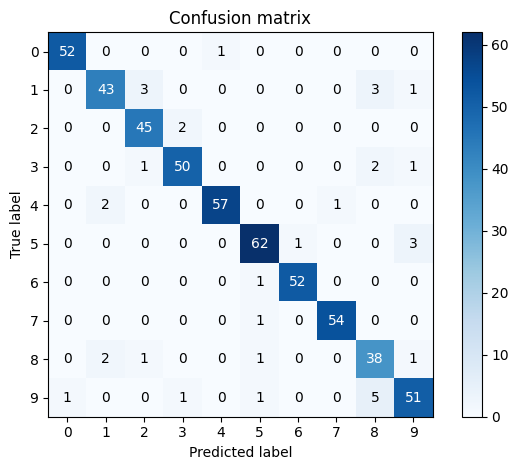

In [473]:
np.set_printoptions(precision=2)
class_names = ["0","1","2","3","4","5","6","7","8","9"]
plot_cm(classes=class_names, cm = cm, title='Confusion matrix')
plt.show()

À partir de notre matrice de confusion, nous constatons que notre modèle présente de bonnes performances pour distinguer les différentes classes représentées par les chiffres de 0 à 9.
La diagonale de cette matrice représente le nombre de vrais positifs pour chaque classe.

Nous récupérons les labels mal classifiés et les visualisons.

In [487]:
"""
Cette fonction nous permet d'afficher les labels mal classés par notre modèle.
"""

def viz_error(result, n=5, digit=None):
    # recuperation des erreurs de classifications
    if digit is not None:
        errors = result[(result['Real Label'] != result['Predicted Label']) & (result['Real Label'] == digit)].index.tolist()
    else :
        errors = result[result['Real Label'] != result['Predicted Label']].index.tolist()
        
        
    # visualisation
    nb_lines = ((n-1)//4)+1
    f, axarr = plt.subplots(nb_lines, 4, figsize=(10, 10))
    f.subplots_adjust(hspace=0.4)
    
    if nb_lines == 1:
        for i in range(4):
            axarr[i].imshow(X_test[errors[i], 1:].reshape((8,8)), cmap='gray')
            axarr[i].set_title(f"Predicted value : {int(result['Predicted Label'][errors[i]])} \n Real value : {result['Real Label'][errors[i]]}",  fontsize = 10)
    else:
        k=0
        m=0
        for i in range(nb_lines):
            for j in range(4):
                k = i+j+m
                if k >= n or k >= len(errors): break
                axarr[i, j].imshow(X_test[errors[k], 1:].reshape((8,8)), cmap='gray')
                axarr[i, j].set_title(f"Predicted value : {int(result['Predicted Label'][errors[k]])} \n Real value : {result['Real Label'][errors[k]]}",  fontsize = 10)
            m = k

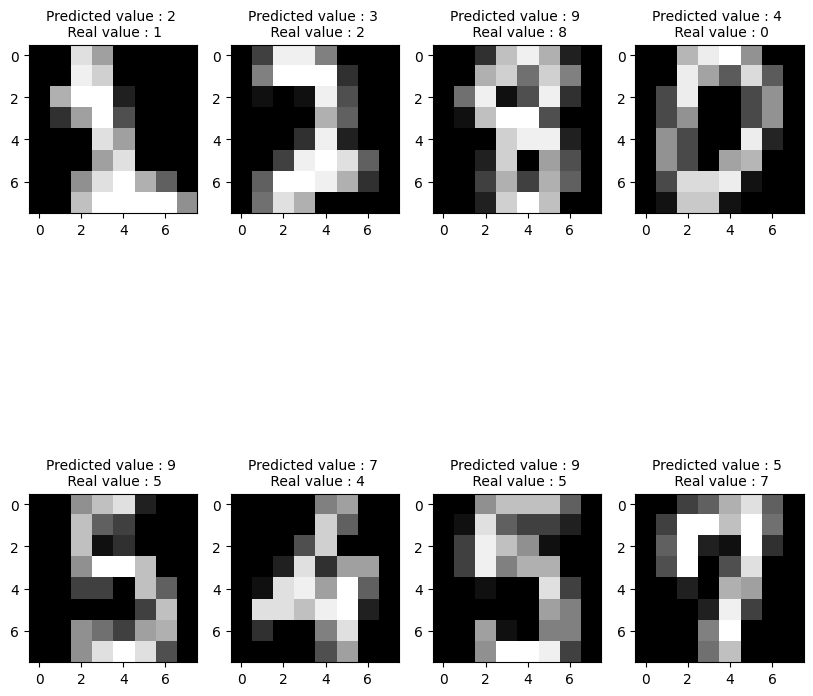

In [488]:
# afficher les 8 premieres erreurs de classification
viz_error(result, 8)

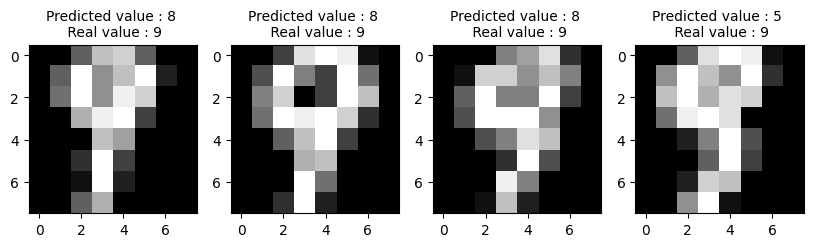

In [489]:
# voici les 8 premières erreurs de classification concernant le chiffre 9.
viz_error(result, 4, digit=9)

### Métriques

In [490]:
# TRUE POSITIVE
TP = np.diag(cm)
# FALSE POSITIVE
FP = cm.sum(axis=0) - np.diag(cm)  
# FALSE NEGATIVE
FN = cm.sum(axis=1) - np.diag(cm)
# TRUE NEGATIVE
TN = cm.sum() - (FP + FN + TP)

In [491]:
# Précision
precision = TP/(TP+FP)

# Rappel
rappel = TP/(TP+FN)

# F1 score
F1 = (2*precision*rappel)/(precision+rappel)

# Accuracy
accuracy = (TP+TN)/(TP+FP+FN+TN)

In [492]:
metrics = pd.DataFrame({
    'Label': [i for i in range(10)],
    'Précision': precision,
    'Rappel': rappel,
    'F1-score': F1,
    'Accuracy': accuracy
})
metrics

,Label,Précision,Rappel,F1-score,Accuracy
0,0,0.981132,0.981132,0.981132,0.996296
1,1,0.914894,0.860000,0.886598,0.979630
2,2,0.900000,0.957447,0.927835,0.987037
3,3,0.943396,0.925926,0.934579,0.987037
4,4,0.982759,0.950000,0.966102,0.992593
5,5,0.939394,0.939394,0.939394,0.985185
6,6,0.981132,0.981132,0.981132,0.996296
7,7,0.981818,0.981818,0.981818,0.996296
8,8,0.791667,0.883721,0.835165,0.972222
9,9,0.894737,0.864407,0.879310,0.974074


Notre tableau des différentes métriques démontre que nos différents modèles ont de bonnes performances pour classifier chaque label.

In [ ]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

### One-vs-Rest multiclass ROC

In [519]:
"""
    digit : Chiffres (label)
    y_test: nos données de tests
    real_pred; les predictions faites par notre modèle
    plot : afficher le graphique ou uniquement AUC
    
    Retourne une courbe ROC et son AUC
    
    Cette fonction nous permet d'afficher la courbe ROC pour chaque modèle de nos différentes classes par rapport à toutes les autres.

"""

def roc_One_vs_Rest(digit, y_test, real_pred, plot=True):
    n_fpr, n_tpr, _ = roc_curve(get_t(digit, y_test), [0 for _ in range(len(y_test))])
    ls_fpr, ls_tpr, trh = roc_curve(get_t(digit, y_test), real_pred[:,digit])
    
    if plot:
        # plot the roc curve for the model
        plt.plot(n_fpr, n_tpr, linestyle='--')
        plt.plot(ls_fpr, ls_tpr, marker='.', label=f"Classification LS pour le chiffre {digit} ")
        # axis labels
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        # show the legend
        plt.legend()
        
        plt.title("Courbe ROC")
        # show the plot
        plt.show()
        
    print(f"AUC du chiffres {digit} = {round(auc(ls_fpr, ls_tpr), 4)}")

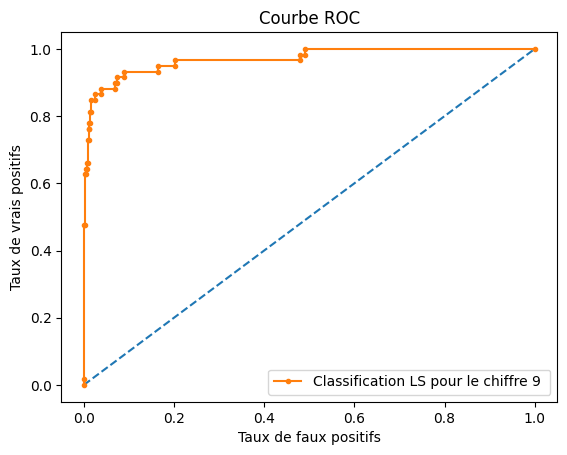

AUC du chiffres 9 = 0.9697


In [520]:
# courbe roc pour le label 9, vous pouvez choisir n'importe quel label
roc_One_vs_Rest(9, y_test, real_pred)

La courbe ROC confirme les performances de notre classification, avec une aire sous la courbe élevée pour toutes nos classes.

In [521]:
for i in range(10):
   roc_One_vs_Rest(i, y_test, real_pred, plot=False)

AUC du chiffres 0 = 0.9998
AUC du chiffres 1 = 0.99
AUC du chiffres 2 = 0.9957
AUC du chiffres 3 = 0.9878
AUC du chiffres 4 = 0.9998
AUC du chiffres 5 = 0.9995
AUC du chiffres 6 = 0.9886
AUC du chiffres 7 = 0.9933
AUC du chiffres 8 = 0.9858
AUC du chiffres 9 = 0.9697
